In [1]:
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
import rasterio
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [3]:
df = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')
test.head(3)
# Sample submission:
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,ID,Label
0,00MZGKU,0
1,015JA41,0
2,01POB64,0


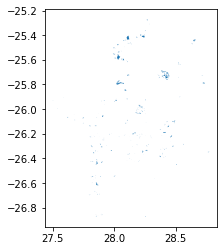

In [4]:
gp = gpd.read_file('GP_Informal_settlement2017.shp')
gp.plot()

In [5]:
from shapely.geometry import Polygon, Point
lats = []
lons = []
labels = []
for i in tqdm(range(400000)):
    lon = 28 + random.random()*0.5
    lat = -26 + random.random()*0.5
    p = Point(lon, lat)
    IN = False
    for geom in gp.geometry:
        if p.within(geom):
            IN = True
    lats.append(lat)
    lons.append(lon)
    labels.append(IN)
ls = pd.DataFrame({
    'LAT':lats,
    'LON':lons,
    'Label':labels
})
ls.sample(10)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,LAT,LON,Label
193860,-25.671901,28.326396,False
396748,-25.702363,28.371440,False
293982,-25.773937,28.086163,False
93079,-25.790613,28.434580,False
11772,-25.982115,28.396884,False
222029,-25.572067,28.059789,False
370053,-25.523278,28.195255,False
83072,-25.700689,28.498185,False
325366,-25.509059,28.427528,False
205300,-25.903541,28.369811,False


In [6]:
ls.Label.value_counts()

False    395242
True       4758
Name: Label, dtype: int64

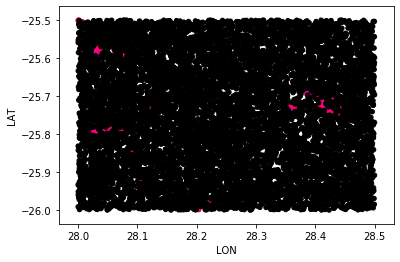

In [7]:
l_sample = pd.concat([ls.loc[ls.Label==True], ls.loc[ls.Label==False].sample(frac=0.025)])
l_sample.plot(kind='scatter', x='LON', y='LAT', c=l_sample['Label'].map(lambda x: (1, 0, 0.5) if x else (0, 0, 0)))

In [8]:
df['Label'].value_counts()/df.shape[0]

False    0.744452
True     0.255548
Name: Label, dtype: float64

In [9]:
l_sample.shape

(14639, 3)

In [10]:
l_sample.Label.value_counts()/l_sample.shape[0]

False    0.674978
True     0.325022
Name: Label, dtype: float64

In [11]:
l_sample['ID']='ID'+l_sample.index.astype(str)

In [12]:
df=pd.concat([df,l_sample])
df.shape

(18920, 4)

In [13]:
df.Label.value_counts()/df.shape[0]

False    0.690698
True     0.309302
Name: Label, dtype: float64

In [14]:
dataset = rasterio.open('2528C.tif') 
# Load bands into RAM
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)
# Load bands into RAM

# # Let's do 5 points for now - use df.values to do this for the whole dataset
for ID, lat, lon, label in df.sample(2).values:
    
    # Blank image
    im = np.zeros((200,200,3), np.uint8)
    
    # Get pixel coords
    row, col = dataset.index(lon, lat)
    
    # Add image data
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    # Save with the location in the name
    im = Image.fromarray(im)
    pth = 'small_images/negative/'
    if label == True:
        pth = 'small_images/positive/'
    im.save(pth+f"im_{ID}_{lat}_{lon}.jpeg")

In [15]:
bad_IDs = []
for i,x in df.iterrows():
    row, col = dataset.index(x['LON'],x['LAT'])
    if band[row-100:row+100, col-100:col+100].shape != (200,200):
#         print(lon,lat)
        bad_IDs.append(x['ID'])

In [16]:
df = df[~df['ID'].isin(list(set(bad_IDs)))]

In [17]:
df['Label'].value_counts()

False    12970
True      5838
Name: Label, dtype: int64

In [18]:
# Get the image:
# random_seed(42)
def get_x(ID):
    row = df.loc[df.ID == ID]
    lat, lon = row['LAT'].values[0], row['LON'].values[0]
    im = np.zeros((200,200,3), np.uint8)
    row, col = dataset.index(lon, lat)
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    return im

# And the label
def get_y(ID):
    row = df.loc[df.ID == ID]
    return int(row['Label'].values[0])

# Get the list of Image IDS:
def get_im_ids(path):
    return df.ID.values


def get_data(fold_id,folds,size,bs):
# test_img = ImageList.from_df(test_df, path=data_folder, folder='images')
    tfms = [Rotate(4),Flip(),Brightness(0.5,p=0.25),Zoom(max_zoom=1.1,p=0.25)]
    # And build the datablock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_im_ids,
        get_x=get_x,
        get_y=get_y, 
        splitter=KFSplitter(fold_id=fold_id,folds=folds),
        batch_tfms=tfms,
        item_tfms=[Resize(size)]
    )
    dls = dblock.dataloaders(Path(''), bs=bs)
    return dls


In [19]:
path = Path('./small_images/')
bs = 64
kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=[x for x in df['ID']]))
len(folds)
# folds

10

In [20]:
def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

In [21]:
dls = get_data(fold_id=0,folds=folds,size=224,bs=16)

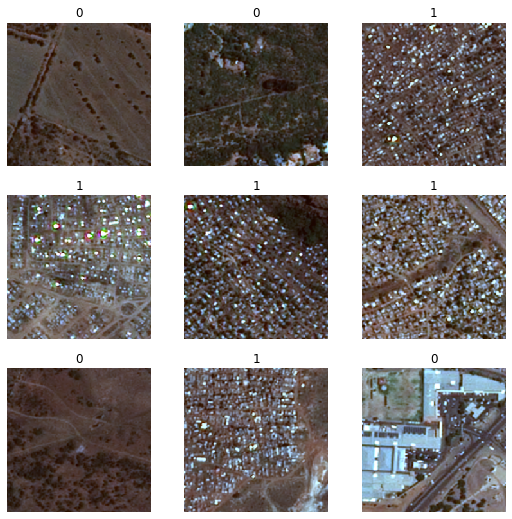

In [22]:
dls.show_batch()

In [23]:

for fold_id in range(kf):
    print(f'Running Fold-{fold_id}')
    dls = dls = get_data(fold_id=fold_id,folds=folds,size=200,bs=16)
    learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
    learn.fine_tune(1)
    learn.save(f'model-{fold_id}')

Running Fold-0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230731,0.094797,0.035097,0.964903,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.093353,0.044590,0.013826,0.986174,02:05


Running Fold-1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.209331,0.115806,0.037490,0.962510,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.111792,0.055295,0.017017,0.982983,02:05


Running Fold-2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.236745,0.114699,0.043074,0.956926,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.099044,0.053706,0.016751,0.983249,02:06


Running Fold-3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.186152,0.125401,0.045998,0.954002,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.112331,0.055897,0.018080,0.981920,02:06


Running Fold-4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.202488,0.124933,0.041478,0.958522,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.129411,0.058389,0.017549,0.982451,02:06


Running Fold-5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.215571,0.126061,0.048657,0.951343,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.104299,0.043751,0.013560,0.986440,02:06


Running Fold-6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.226144,0.097741,0.036161,0.963839,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.090507,0.048394,0.014890,0.985110,02:06


Running Fold-7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.216932,0.124137,0.045733,0.954268,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.109335,0.055310,0.021803,0.978197,02:06


Running Fold-8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.197697,0.125321,0.046796,0.953204,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.092519,0.058108,0.020739,0.979261,02:06


Running Fold-9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.211313,0.107023,0.036426,0.963574,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.091792,0.054950,0.018346,0.981654,02:06


In [24]:
test = pd.read_csv('Test.csv')
test.head(3)

,ID,LAT,LON
0,00MZGKU,-29.8920,30.8575
1,015JA41,-29.8905,30.8705
2,01POB64,-29.9615,30.8950


In [25]:
dataset = rasterio.open('2930D.tif') # We'll use rasterio for all raster operations

In [26]:
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [27]:
test['Label']=0
df=pd.concat([df,test])

In [28]:
idx = test['ID'].values
tdl = learn.dls.test_dl(idx)

In [30]:
def get_k_fold_preds(kf):
    preds = []
    for fold_id in tqdm(range(kf)):
        learn.load(f'model-{fold_id}')
        test_preds = array(learn.tta(dl=tdl)[0][:,1])
        preds.append(test_preds)
        
    return preds

In [31]:
ttapreds = get_k_fold_preds(kf)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


preds = get_k_fold_preds(kf)

In [32]:
np.mean(ttapreds,0)

array([0.02788267, 0.04425619, 0.09881065, ..., 0.3473687 , 0.12717739,
       0.00250165], dtype=float32)

In [33]:
test['Label']=np.mean(ttapreds,0)
test

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.027883
1,015JA41,-29.8905,30.8705,0.044256
2,01POB64,-29.9615,30.8950,0.098811
3,02125F8,-29.9660,30.8500,0.046035
4,03E8VFF,-29.9080,30.8760,0.069587
...,...,...,...,...
2608,ZXTOTE4,-29.9390,30.8770,0.002607
2609,ZZ37046,-29.9675,30.8730,0.200481
2610,ZZKO0HF,-29.9755,30.9050,0.347369
2611,ZZQN3L6,-29.9115,30.8625,0.127177


In [34]:
sum(test['Label']>0.5)

187

In [35]:
test[['ID','Label']].to_csv('Sub_resnet18_4Lac.csv',index=False)

In [36]:
test['Label'].describe()

count    2613.000000
mean        0.147478
std         0.189155
min         0.000203
25%         0.016176
50%         0.071820
75%         0.195653
max         0.961944
Name: Label, dtype: float64